In [1]:
import yaml
import subprocess
import glob
import numpy as np
import os
import dill
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
import os

In [2]:
# Function to replace the placeholder with the relaxation parameter in the template YAML file
def create_yaml_from_template(template_path, output_path, placeholder, new_value):
    with open(template_path, 'r') as file:
        content = file.read()

    # Replace the placeholder with the new relaxation parameter value
    updated_content = content.replace(placeholder, str(new_value))

    # Write the updated content to the output file
    with open(output_path, 'w') as file:
        file.write(updated_content)

# Function to run the Julia command
def run_julia_command():
    for filename in os.listdir(os.getcwd()):
        if filename.endswith('.csv'):
            file_path = os.path.join(os.getcwd(), filename)
            # Delete the file
            os.remove(file_path)
    command = ["julia", "--project=@.", "/Users/bphung/Work/software/Norma.jl/src/Norma.jl", "cubes.yaml"]
    subprocess.run(command, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.PIPE, text=True)

def extract_number(filename):
    match = re.search(r'convergence_values-(\d+)\.csv', filename)
    return int(match.group(1)) if match else float('inf')
# Function to read the latest convergence values CSV file into a NumPy array
def read_latest_convergence_values():
    # Get the latest file matching the pattern
    list_of_files = glob.glob("convergence_values-*.csv")
    # Sort the files using the extracted number
    sorted_files = sorted(list_of_files, key=extract_number)
    # Read the CSV file into a NumPy array
    data = [ np.loadtxt(latest_file, delimiter=',', skiprows=0) for latest_file in sorted_files ]
    return data

def calculate_convergence_rate(errors):
    """Calculate the convergence rate for the last half of the error values."""
    n = len(errors)
    if n < 2:
        #print(errors)
        raise ValueError("Not enough data points to calculate convergence rate.")
    
    # Extract the last half of the errors
    last_half_errors = errors[n // 2:]

    # Calculate log of the errors
    log_errors = np.log(last_half_errors)

    # Create an array of iteration indices for the last half
    iterations = np.arange(len(log_errors))

    # Fit a linear polynomial (degree 1) to the log errors
    slope, intercept = np.polyfit(iterations, log_errors, 1)
    return -slope

In [3]:
rerun = False
if os.path.exists('iteration_count.pkl') and rerun == False:
    # Load the file
    with open("rates_a.pkl", 'rb') as file:
        rate_of_convergence_a = dill.load(file)
    with open("rates_r.pkl", 'rb') as file:
        rate_of_convergence_r = dill.load(file)
    with open("relaxation_params.pkl", 'rb') as file:
        relaxation_parameters = dill.load(file)
    with open("iteration_count.pkl", 'rb') as file:
        number_of_iterations = dill.load(file)

    print("File loaded successfully.")
else:

    number_of_iterations = []
    rate_of_convergence_a = []
    rate_of_convergence_r = []
    relaxation_parameters = np.linspace(.1,1.0,19)
    for relaxation in relaxation_parameters:
        template_file_path = "cubes-template.yaml"
        output_file_path = "cubes.yaml"
        placeholder = "{replace_yaml}"  # Placeholder to be replaced
        new_relaxation_value = relaxation  # Change this to the desired relaxation parameter value

        # Create cubes.yaml from the template
        create_yaml_from_template(template_file_path, output_file_path, placeholder, new_relaxation_value)

        # Run the Julia command
        run_julia_command()

        # Read the latest convergence values into a NumPy array
        convergence_data = read_latest_convergence_values()
        convergence_data = [ cd[np.nonzero(cd)] for cd in convergence_data ] 
        convergence_absolute_all = [ cd[0::2] for cd in convergence_data ]
        convergence_relative_all = [ cd[1::2] for cd in convergence_data ]
        number_of_iterations.append([ len(cd) // 2 for cd in convergence_data] )

        rate_of_convergence_a_local = []
        rate_of_convergence_r_local = []
        for (convergence_absolute, convergence_relative) in zip(convergence_absolute_all, convergence_relative_all):
            # print(convergence_absolute)
            # print(convergence_relative)
            try:
                convergence_rate_a = calculate_convergence_rate(convergence_absolute)
                
                convergence_rate_r = calculate_convergence_rate(convergence_relative)
            except:
                convergence_rate_a = np.inf
                convergence_rate_r = np.inf

            rate_of_convergence_a_local.append(convergence_rate_a)
            rate_of_convergence_r_local.append(convergence_rate_r)
            
        rate_of_convergence_a.append(rate_of_convergence_a_local)
        rate_of_convergence_r.append(rate_of_convergence_r_local)

    with open("rates_a.pkl", 'wb') as file:
        dill.dump(rate_of_convergence_a, file)
    with open("rates_r.pkl", 'wb') as file:
        dill.dump(rate_of_convergence_r, file)
    with open("relaxation_params.pkl", 'wb') as file:
        dill.dump(relaxation_parameters, file)
    with open("iteration_count.pkl", 'wb') as file:
        dill.dump(number_of_iterations, file)

File loaded successfully.


In [4]:
def plot_qoi_heatmap(data, relaxation_params, time_points, label='QOI'):
    """
    Plots a heatmap for a 2D grid representing QOIs.

    Parameters:
    - data: 2D array-like, where each element represents the QOI at a given relaxation parameter and time.
    - relaxation_params: 1D array-like, relaxation parameters.
    - time_points: 1D array-like, time points.
    """
    # Create a figure
    plt.figure(figsize=(10, 8))
    data = data.T
    # Create the heatmap
    plt.imshow(data[::-1,:], aspect='auto', cmap='viridis', 
               extent=[relaxation_params[0], relaxation_params[-1], time_points[0], time_points[-1]])

    # Add color bar
    plt.colorbar(label=label)

    # Set labels and title
    plt.xlabel('Relaxation Parameter')
    plt.ylabel('Time (s)')
    #plt.title('')
    plt.savefig(f'{label}.png')
    # Show the plot
    plt.show()

time_points = np.linspace(-1.e-4,0.0021,23)
# print(number_of_iterations)
# print(np.array(rate_of_convergence_a).shape)


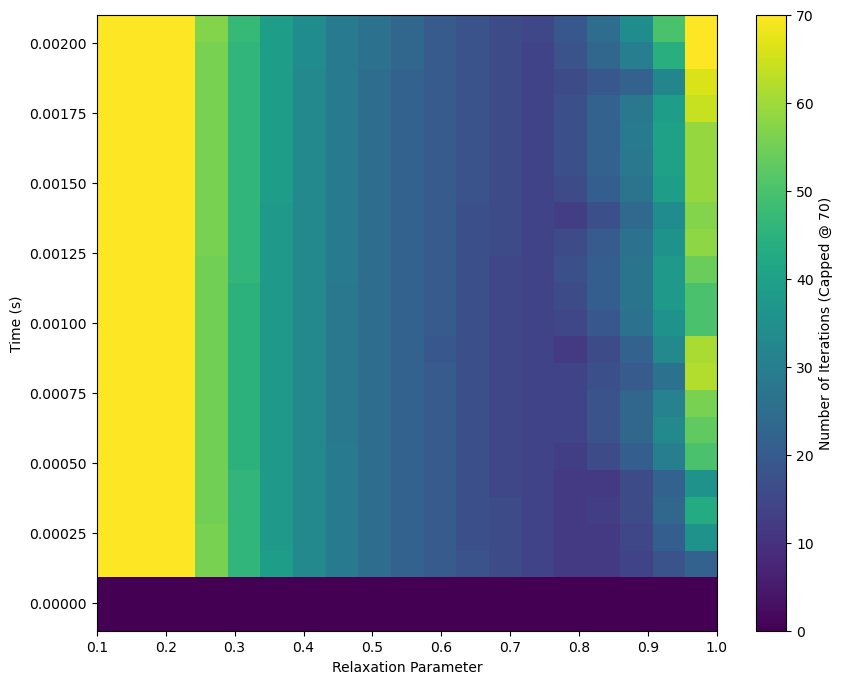

In [5]:
number_of_iterations = np.array(number_of_iterations)
capped_number_of_iters = number_of_iterations
capped_number_of_iters[capped_number_of_iters > 70] = 70
plot_qoi_heatmap(capped_number_of_iters, relaxation_parameters, time_points, "Number of Iterations (Capped @ 70)")

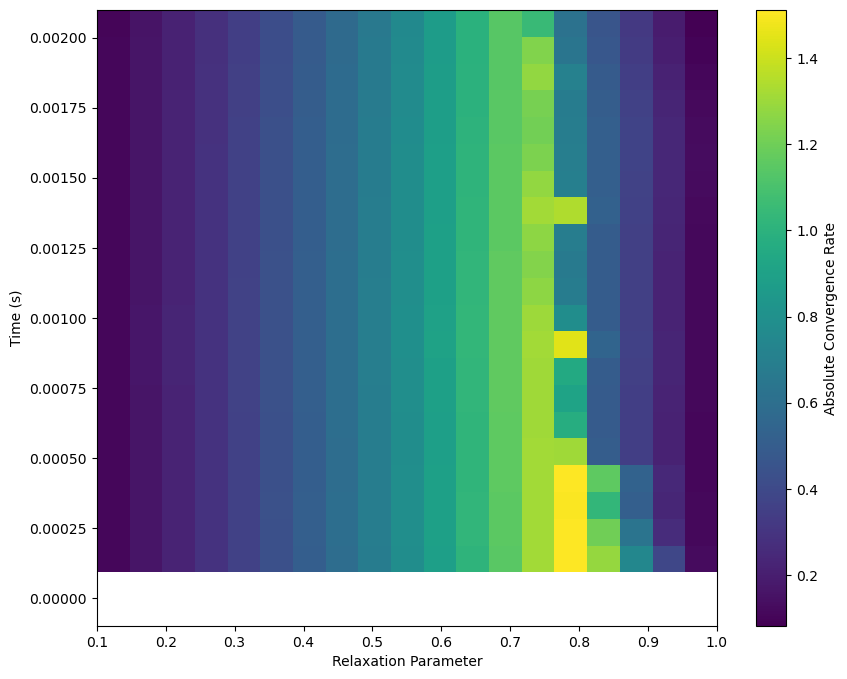

In [6]:
#plt.plot(time_points,rate_of_convergence_a[2])
#print(rate_of_convergence_a[2])
plot_qoi_heatmap(np.array(rate_of_convergence_a), relaxation_parameters, time_points, "Absolute Convergence Rate")

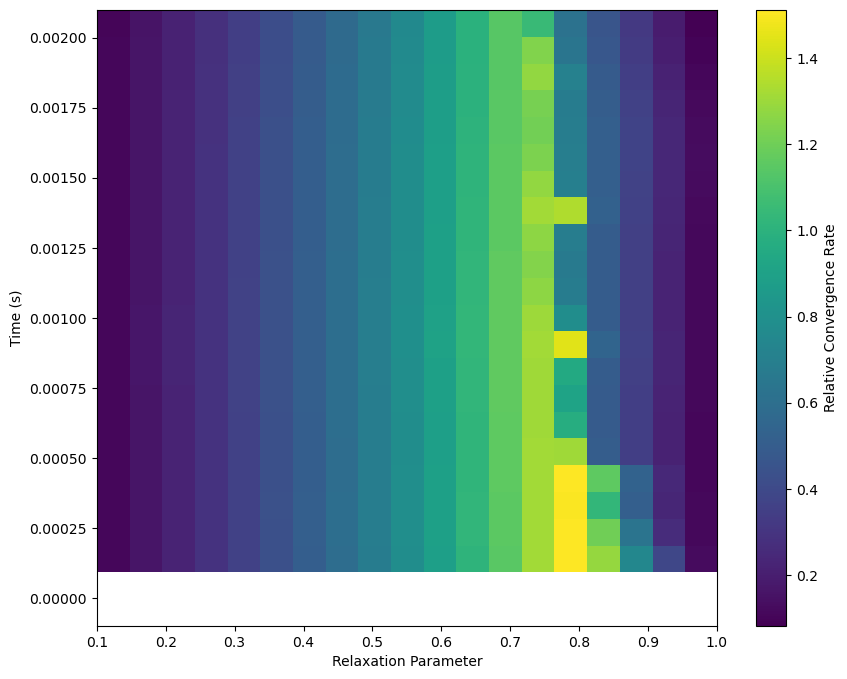

In [7]:
plot_qoi_heatmap(np.array(rate_of_convergence_r), relaxation_parameters, time_points, "Relative Convergence Rate")

In [8]:
for filename in os.listdir(os.getcwd()):
    if filename.endswith('.csv'):
        file_path = os.path.join(os.getcwd(), filename)
        # Delete the file
        os.remove(file_path)